In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pygame
import random

width_global = 20
height_global = 20

class CrossyRoadEnv(gym.Env):
    def __init__(self):
        super().__init__()

        self.width = width_global
        self.height = height_global
        self.max_steps = self.width * self.height 

        self.observation_space = spaces.Box(low=0, high=5, shape=(self.height, self.width), dtype=np.int32)
        self.action_space = spaces.Discrete(5)

        pygame.init()
        self.screen = pygame.display.set_mode((self.width * 40, self.height * 40))
        self.clock = pygame.time.Clock()

        self.success_count = 0
        self.last_positions = []

    def _get_obs(self):
        grid = np.zeros((self.height, self.width), dtype=np.int32)
        grid[self.agent_pos[1], self.agent_pos[0]] = 1
        for rock in self.rocks:
            grid[rock[1], rock[0]] = 5
        
        for car in self.cars:
            grid[car[1], car[0]] = 4
        
        return grid

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.agent_pos = [self.width // 2, self.height - 1]
        self.done = False
        self.score = 0
        self.steps = 0
        self.last_positions = []

        self.rocks = []
        
        self.cars = []
        self.car_rows = []
        self.car_directions = {}

        forbidden_rows = [0, self.height - 1, self.height - 2]

        rocks_count = np.random.randint(0.03 * self.width * self.height, 0.04 * self.width * self.height)
        for _ in range(rocks_count):
            attempt = 0
            while attempt < 100:
                rx = random.randint(1, self.width - 2)
                ry = random.randint(1, self.height - 3)
                if ry not in forbidden_rows and [rx, ry] not in self.rocks and [rx, ry] != self.agent_pos:
                    self.rocks.append([rx, ry])
                    break
                attempt += 1

        potential_car_rows = [y for y in range(1, self.height - 2) if y not in forbidden_rows]
        potential_car_rows = [y for y in potential_car_rows if y not in [rock[1] for rock in self.rocks]]
        random.shuffle(potential_car_rows)
        self.car_rows = potential_car_rows[:3]

        for row in self.car_rows:
            self.car_directions[row] = random.choice(["left", "right"])
            for _ in range(random.randint(1, 2)):
                cx = random.randint(0, self.width - 1)
                self.cars.append([cx, row])

        return self._get_obs(), {}

    def step(self, action):
        if self.done:
            return self._get_obs(), 0, True, False, {"success_count": self.success_count}

        reward = 0.0
        self.steps += 1

        new_cars = []
        for x, y in self.cars:
            if self.car_directions[y] == "left":
                x = (x - 1) % self.width
            else:
                x = (x + 1) % self.width
            new_cars.append([x, y])
        self.cars = new_cars

        if self.agent_pos in self.cars:
            reward -= 1.0
            self.done = True
            return self._get_obs(), reward, self.done, False, {"success_count": self.success_count}

        x, y = self.agent_pos
        new_x, new_y = x, y

        if action == 0 and y > 0:
            new_y -= 1
        elif action == 1 and y < self.height - 1:
            new_y += 1
        elif action == 2 and x > 0:
            new_x -= 1
        elif action == 3 and x < self.width - 1:
            new_x += 1
        elif action == 4:
            reward -= 0.05

        if [new_x, new_y] in self.rocks:
            reward -= 0.2
        elif [new_x, new_y] in self.cars:
            reward -= 1.0
            self.done = True
        else:
            if new_y < y:
                reward += 0.1
            elif new_y > y:
                reward -= 0.05
            self.agent_pos = [new_x, new_y]

        self.last_positions.append(tuple(self.agent_pos))
        if len(self.last_positions) > 10:
            self.last_positions.pop(0)
            if all(pos == tuple(self.agent_pos) for pos in self.last_positions):
                reward -= 1.2

        if self.agent_pos[1] == 0:
            reward += 10.0
            self.done = True
            self.success_count += 1
        elif self.agent_pos[1] == self.height / 2:
            reward += 5.0

        if self.steps >= self.max_steps:
            self.done = True

        return self._get_obs(), reward, self.done, False, {"success_count": self.success_count}

    def render(self):
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                exit()

        self.screen.fill((170, 220, 60))

        for row in self.car_rows:
            for x in range(self.width):
                pygame.draw.rect(self.screen, (50, 50, 50), (x * 40, row * 40, 40, 40))

        for rock in self.rocks:
            pygame.draw.rect(self.screen, (100, 100, 100), (rock[0] * 40, rock[1] * 40, 40, 40))

        for car in self.cars:
            pygame.draw.rect(self.screen, (255, 0, 0), (car[0] * 40, car[1] * 40, 40, 40))

        pygame.draw.circle(self.screen, (255, 200, 0),
                           (self.agent_pos[0] * 40 + 20, self.agent_pos[1] * 40 + 20), 20)

        pygame.display.flip()
        self.clock.tick(12)

    def close(self):
        pygame.quit()


In [6]:
# if __name__ == "__main__":
#     env = CrossyRoadEnv()
#     obs, _ = env.reset()
#     for _ in range(100):
#         action = env.action_space.sample()
#         obs, reward, done, _, _ = env.step(action)
#         env.render()
#         if done:
#             obs, _ = env.reset()
#     env.close()

In [2]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

# Zakładam, że masz klasę CrossyRoadEnv
# from your_module import CrossyRoadEnv

class FlattenObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        shape = env.observation_space.shape[0] * env.observation_space.shape[1]
        self.observation_space = gym.spaces.Box(low=0, high=5, shape=(shape,), dtype=np.float32)

    def observation(self, observation):
        return observation.astype(np.float32).flatten()


Using cuda device
Wrapping the env in a DummyVecEnv.


/home/przemek/studia/inteligencja_obliczeniowa/projekt4_2/.venv/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 112      |
|    ep_rew_mean     | 5.31     |
| time/              |          |
|    fps             | 1512     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 1024     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 143         |
|    ep_rew_mean          | 12.7        |
| time/                   |             |
|    fps                  | 1333        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.006732836 |
|    clip_fraction        | 0.0488      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.61       |
|    explained_variance   | -0.00211    |
|    learning_rate        | 0.

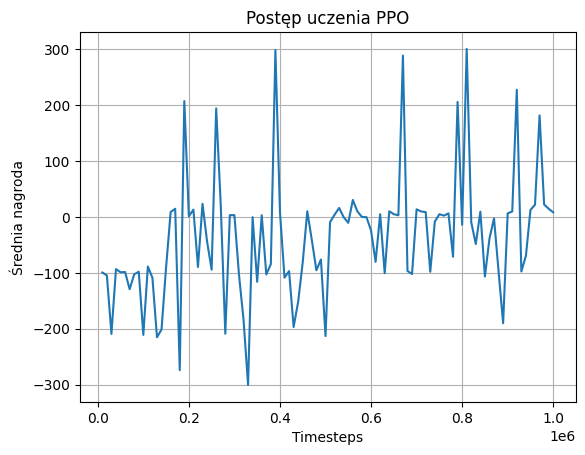

In [ ]:
# Tworzenie środowiska z monitorowaniem
env = CrossyRoadEnv()
env = FlattenObservationWrapper(env)
env = Monitor(env)  # loguje dane do pliku

check_env(env, warn=True)

# Callback do ewaluacji i logowania nagród
eval_env = CrossyRoadEnv()
eval_env = FlattenObservationWrapper(eval_env)
eval_env = Monitor(eval_env)

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path="./logs/",
    log_path="./logs/",
    eval_freq=10_000,
    deterministic=True,
    render=False
)

model = PPO(
    policy="MlpPolicy",
    env=env,
    policy_kwargs=dict(net_arch=[256, 256]),
    verbose=1,
    n_steps=1024,
    batch_size=128,
    n_epochs=10,
    learning_rate=1e-4,
    gamma=0.99,
    gae_lambda=0.92,
    clip_range=0.2,
    vf_coef=0.6,
    ent_coef=0.02,
    normalize_advantage=True,
    device="cuda" if torch.cuda.is_available() else "cpu"
)

model.learn(total_timesteps=1_000_000, callback=eval_callback)

model.save("ppo_crossyroad")

# Wczytanie i narysowanie wykresu nagród
results_file = "./logs/evaluations.npz"
if os.path.exists(results_file):
    data = np.load(results_file)
    timesteps = data["timesteps"]
    results = data["results"]

    mean_rewards = results.mean(axis=1)

    plt.plot(timesteps, mean_rewards)
    plt.xlabel("Timesteps")
    plt.ylabel("Średnia nagroda")
    plt.title("Postęp uczenia PPO")
    plt.grid(True)
    plt.show()
else:
    print("Brak pliku z logami ewaluacyjnymi.")


In [4]:
from stable_baselines3 import PPO
import time

env = CrossyRoadEnv()
env = FlattenObservationWrapper(env)

model = PPO.load("ppo_crossyroad_24_suc")

timeout_seconds = 60
all_successes = 0
tests = 5

for i in range(tests):

    success_count = 0
    total_episodes = 0
    start_time = time.time()

    obs, _ = env.reset()
    done = False
    while (time.time() - start_time) < timeout_seconds:
        obs, _ = env.reset()
        done = False

        while not done:
            action, _states = model.predict(obs)
            obs, reward, done, _, _ = env.step(action)
            env.render()

            if done :
                total_episodes += 1
                if  env.env.agent_pos[1] == 0:
                    success_count += 1
            

    print(f"✔️ Test nr {i+1} zakończony. Procent sukcesów: {(success_count / total_episodes) * 100:.2f}%")
    all_successes += success_count

print(f"Łączna liczba sukcesów we wszystkich testach: {all_successes}")
print(f"Średnia liczba sukcesów na test: {all_successes / tests:.2f}")


env.close()


/home/przemek/studia/inteligencja_obliczeniowa/projekt4_2/.venv/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


✔️ Test nr 1 zakończony. Procent sukcesów: 29.41%
✔️ Test nr 2 zakończony. Procent sukcesów: 36.36%
✔️ Test nr 3 zakończony. Procent sukcesów: 11.11%
✔️ Test nr 4 zakończony. Procent sukcesów: 50.00%
✔️ Test nr 5 zakończony. Procent sukcesów: 37.50%
Łączna liczba sukcesów we wszystkich testach: 16
Średnia liczba sukcesów na test: 3.20
